In [8]:
#@title Librerias
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
from scipy.integrate import quad, fixed_quad, trapezoid, simpson
from sympy import symbols, diff, integrate, lambdify
from typing import Callable

# Parcial II - Métodos Computacionales (Integrales y Matrices)
**2024-2**

---

*Nombre:*

*Identificación:*

---
* Sea honest@
* El uso de herramientas de IA no está permitido
* Puede consultar la documentación de las librerias.
* Sea ordendado dando la solución a cada punto.
* *Asegurese que el notebook corra completamente*
* Suba su notebook al GitHub (en su carpeta) y recuerde hacer pull-request

# 1

**(20 puntos)**
Considera la siguiente integral:

$$
I = \int_0^1 \int_{x^2}^{x+1} \int_{y^2}^{y+2} \int_{z^2}^{z+3} (x+y+z+w) \, dw \, dz \, dy \, dx
$$

Encuentre la solución númerica usando unicamente `quad`. Encuentre el error relativo, para esto emplee el siguiente código que usa `nquad`:


```python
# Definir el integrando
integrand = lambda w, z, y, x: x + y + z + w

# Definir los límites usando funciones lambda
w_limits = lambda z, y, x: [z**2, z+3]
z_limits = lambda y, x: [y**2, y+2]
y_limits = lambda x: [x**2, x+1]
x_limits = lambda: [0, 1]

# Calcular la integral usando nquad
result, error = nquad(
    integrand,
    [w_limits, z_limits, y_limits, x_limits]
)

print(f"Resultado de la integral: {result}")
print(f"Error estimado: {error}")
```



Como scipy.integrate quad evalúa integrales de una variable, debemos aplicar el método de manera iterativa, donde los límites de integración dependen de x, con lo que en cada evaluación de quad(f, a, b), dichos límites de integración quedarán en términos de x.

En consecuencia, tras cada integración en términos de una variable, se llama a una segunda función en términos de la variable siguiente.

In [31]:
# @title Aproximación de la integral
def integrand_w(w, x, y, z):
  return x + y + z + w


def integrand_z(z, x, y):
  return quad(integrand_w, z**2, z+3, args=(x, y, z))[0]


def integrand_y(y, x):

  """
  Retorna los límites de integración de z en términos de x, y.

  Args:
    ::

  Returns:
    :f(x, y, z):
  """

  return quad(integrand_z, y**2, y+2, args=(x, y))[0]


def integrand_x(x):

  """
  Calcula la integral en términos del valor de x para retornar los límites de
  integración de y en términos de x.

  Args:
    :x: Límites de integración de x.

  Returns:
    :y: Límites de integración de y en términos de x
  """

  return quad(integrand_y, x**2, x+1, args=(x,))[0]


# Evaluar la integral en términos de x en el intervalo [0, 1]
resultado, error = quad(integrand_x, 0, 1)
print(f"Resultado numérico de la integral: {resultado}")


Resultado numérico de la integral: -0.650097


In [24]:
# @title Integral por nquad
from scipy.integrate import nquad

# Integrando
integrando = lambda w, z, y, x: x + y + z + w

# Límites usando funciones lambda
limite_w = lambda z, y, x: [z**2, z + 3]
limite_z = lambda y, x: [y**2, y + 2]
limite_y = lambda x: [x**2, x + 1]
limite_x = [0, 1]

# Integral usando nquad
resultado_nquad, error = nquad(integrando, [limite_w, limite_z, limite_y, limite_x])

# Error relativo
error_relativo = abs(resultado - resultado_nquad) / abs(resultado_nquad)

# Imprimir el resultado y el error relativo
print(f"Resultado de la integral (nquad): {resultado_nquad}")
print(f"Error estimado (nquad): {error}")
print(f"Error relativo: {error_relativo}")

Resultado de la integral (nquad): -0.6500971589021813
Error estimado (nquad): 1.8391891749223705e-12
Error relativo: 464649919.8204275


# 2

**(40 puntos)**
Un lazo de corriente de radio $a$  transporta una corriente $I$ en el punto P que está a una distancia $r$ del centro del lazo con coordenadas esféricas (r, θ, φ). Resuelve para la componente φ del potencial vectorial en el punto $P$ en términos de integrales elípticas:

\begin{equation}
A_{\phi}(r, \theta)=\frac{\mu_0}{4\pi}\frac{4Ia}{\sqrt{a^2+r^2+2ar\sin \theta}}\left(\frac{(2-k^2)K(k)-2E(k)}{k^2} \right)
\end{equation}

donde

\begin{equation}
K(k)=\int_{0}^{\pi/2} \frac{\mathrm{d\phi}}{\sqrt{1-k^2\sin^2\phi}}
\end{equation}

\begin{equation}
E(k)=\int_{0}^{\pi/2} \mathrm{d\phi} \sqrt{1-k^2\sin^2\phi}
\end{equation}

\begin{equation}
k^2=\frac{4ar\sin\theta}{a^2+r^2+2ar\sin\theta}
\end{equation}

Aquí, $K(k)$ es una integral elíptica completa del primer tipo y $E(k)$ es una integral elíptica completa del segundo tipo.


Para
* $a$ = 1,
* $I$ = 3,
* $μ0/4π$ = 1


Usando funciones explicitas explique claramente las entradas, salidas y procedimientos dentro de las mismas. Recuerde para resolver las integrales usar `quad` y grafique para:

*a)* $A_φ(r = 1.1, θ)$ vs. $0\leq θ\leq \pi$

*b)* $A_φ(r, θ = π∕3)$ vs. $0\leq r \leq 10$

Tenga cuidado con la convergencia de su integral



In [63]:
# @title Definición de funciones
def kk(a: float, r: float, tetha: np.ndarray) -> np.ndarray:

  """
  La función calcula todos los valores de k^2 para θ en [0, π]

  Args:
    :constantes: Valores de las constantes dadas
    :tetha: Vector de valores de θ

  Returns:
    Vector de valores de k^2
  """

  return (4*a*r*np.sin(tetha)) / (a**2 + r**2 + 2*a*r*np.sin(tetha))


def integrando_K(k_val: float) -> Callable[[float], float]:

  """
  La función retorna una función tipo lambda para cada valor de k^2, lo que
  permite evaluar la integral K(k) por algún método, como scipy.quad.

  Args:
    :k_val: Valor de k^2
    :phi: Vector de valores de phi

  Returns:
    Función lambda
  """

  return lambda phi: 1 / (1 - k_val * np.sin(phi)**2)**0.5


def integrando_E(k_val: float) -> Callable[[float], float]:

  """
  La función retorna una función tipo lambda para cada valor de k^2, lo que
  permite evaluar la integral K(k) por algún método, como scipy.quad.

  Args:
    :k_val: Valor de k^2
    :phi: Vector de valores de phi

  Returns:
    Función lambda
  """

  return lambda phi: (1 - k_val * np.sin(phi)**2)**0.5


def K(k_val: float) -> float:

  """
  La integral arroja el valor aproximadio de la integral K(k) por el método
  scipy.quad, lo que permite obtener una buena precisión.

  Args:
    :k_val: Valor de k^2

  Returns:
    Valor de la integral K(k)
  """

  return quad(integrando_K(k_val), 0, np.pi / 2)[0]


def E(k_val: float) -> float:

  """
  La integral arroja el valor aproximadio de la integral E(k) por el método
  scipy.quad, lo que permite obtener una buena precisión.

  Args:
    :k_val: Valor de k^2

  Returns:
    Valor de la integral E(k)
  """

  return quad(integrando_E(k_val), 0, np.pi / 2)[0]


def A_phi(a: float, I: float, mu: float,
          r:float, tetha:np.ndarray) -> np.ndarray:

  """
  La función calcula A_phi(a, I, mu, r, k_val, θ) para los valores de las
  constantes y los valores de θ dados.

  Args:
    :constantes: Valores de las constantes dadas
    :tetha: Vector de valores de θ

  Returns:
    Vector de valores de A_phi(a, I, mu, r, k_val, θ)
  """

  ## Valor para cada una de las integrales de K(k) y E(k).
  valores_K = np.zeros_like(tth)
  valores_E = np.zeros_like(tth)

  for i, k_val  in enumerate(kk(1, 1.1, tth)):
    valores_K[i] = K(k_val)
    valores_E[i] = E(k_val)

  return (mu / (4*np.pi)) * (4*I*a) / ((a**2 + r**2 + 2*a*r*np.sin(tetha))**0.5) * (((2-k_val)*valores_K-2*valores_E) / k_val)


tth = np.linspace(0. , np.pi - 1e-6, 1000)

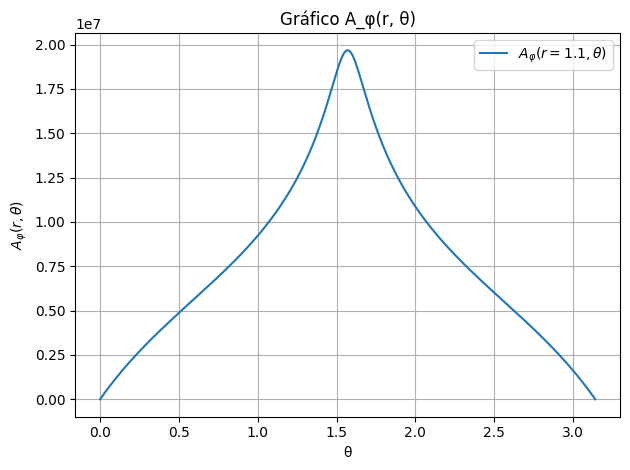

In [64]:
# @title Gráfica de A_φ(1.1, θ) vs θ

plt.title('Gráfico A_φ(r, θ)')
plt.plot(tth, A_phi(1, 3, 4*np.pi, 1.1, tth), label=r'$A_φ(r=1.1, θ)$')
plt.xlabel('θ')
plt.ylabel(r'$A_φ(r, θ)$')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

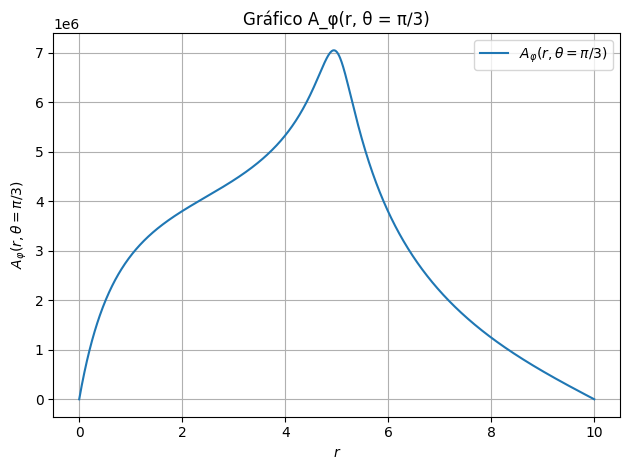

In [65]:
# @title Gráfica de A_φ(r, θ = π∕3) vs. r

r = np.linspace(0, 10, 1000)

plt.title('Gráfico A_φ(r, θ = π∕3)')
plt.plot(r, A_phi(1, 3, 4*np.pi, r, np.pi/3), label=r'$A_φ(r, θ = π∕3)$')
plt.xlabel(r'$r$')
plt.ylabel(r'$A_φ(r, θ = π∕3)$')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


# 3

(**40 puntos**) El **método de la potencia inversa** es una técnica iterativa utilizada para calcular el autovalor de menor magnitud de una matriz cuadrada. Es una variante del **método de la potencia**, que normalmente encuentra el autovalor de mayor magnitud. Para ello, se aprovecha la propiedad de la matriz inversa:

$$ A^{-1} v = \frac{1}{\lambda} v $$


## Algoritmo

El método de la potencia inversa sigue los siguientes pasos:

1. Elegir un vector inicial $x^{(0)}$ no nulo.

2. Para cada iteración $k$, resolver el sistema lineal:
   
   $$ A y^{(k)} = x^{(k-1)} $$
   
   donde $y^{(k)}$ es un **vector intermedio** que se obtiene resolviendo el sistema lineal. Este vector representa la solución del sistema en cada iteración y es crucial para aproximar el autovector de menor autovalor.

3. Normalizar $y^{(k)}$ para obtener un nuevo vector de iteración:
   
   $$ x^{(k)} = \frac{y^{(k)}}{\| y^{(k)} \|} $$
   
4. Aproximar el autovalor mediante el cociente de Rayleigh:
   
   $$ \lambda^{(k)} = \frac{(x^{(k)})^T A x^{(k)}}{(x^{(k)})^T x^{(k)}} $$
   
5. Repetir los pasos anteriores hasta que la diferencia entre valores sucesivos de $\lambda$ sea menor que un umbral de tolerancia.

---

*a)* Escriba una función llamada `potencia_inversa` que dada una matriz A encuentre su valor propio menos dominante (con una tolerancia de 1e-7 usando la norma Euclidiana) y su correspondiente autovector. Para obtener $y^{(k)}$ puede emplear `np.linalg.solve` recordando que $Ay = x$.

*b)* Usando la matriz A, encuentre el $\lambda_{min}$ y el correspondiente autovector. Examine la convergencia de su autovalor en función de las iteraciones, esto es, haga un gráfico de $\lambda(k)$

$$
\begin{bmatrix}
5 & 2 \\
2 & 2
\end{bmatrix}
$$

*c)* Compare su resultado con `np.linalg.eig`

In [ ]:
# Aqui va su código

#4

**(10 puntos)**
Sea $A$ una matriz cuadrada de tamaño $n \times n$. Se sabe que el determinante de una matriz es igual al producto de sus autovalores:

$$
\det(A) = \prod_{i=1}^{n} \lambda_i
$$

donde $\lambda_1, \lambda_2, \dots, \lambda_n$ son los autovalores de $A$.

Usando una matriz aleatoria $A$ de $5\times 5$, demuestre esta propiedad. Puede usar las funciones de `np.linalg`.

In [67]:
# @title Demostración
# Matriz aleatoria de 5x5
A = np.random.rand(5, 5)

# Determinante de A
det_A = np.linalg.det(A)

# Autovalores de A
eigenval = np.linalg.eigvals(A)

# Calcular el producto de los autovalores
prod_eigenvalores = np.prod(eigenval)

print(f"Determinante de A: {det_A}")
print(f"Producto de los autovalores: {prod_eigenvalores}")
print(f"Autovalores de A: {eigenval}")


Determinante de A: -0.012313526222901525
Producto de los autovalores: (-0.012313526222901498+0j)
Autovalores de A: [ 2.71113992+0.j         -0.15372995+0.j          0.15749451+0.j
  0.18183896+0.39309448j  0.18183896-0.39309448j]
